In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as plt

import matplotlib.pyplot as plt

import os 

import cnn_helper
%aimport cnn_helper
cnnh = cnn_helper.CNN_Helper()

# Introduction: Beyond the Feature dimension

Thus far, the data examples we have been using are vectors
- the only dimension is the "feature" dimension
- for example, the names of the features in the feature dimension are `Price, Volume, Open, Close`

The diagram shows (our typical, up to now: 0 non-feature dimensional) feature vector $\x$ matched against pattern $\kernel$
- where the feature dimension is length $3$

<br>
<br>
<table>
    <tr>
        <th><center>Zero non-feature dimensions, length 3 feature dimension</center></th>
    </tr>
    <tr>
        <td><img src="images/conv_0d.png" width=100%></td>
    </tr>
</table>

In this module, we extend "pattern matching" to includes examples that have "shape"
- dimensions beyond the feature dimension

The extended examples will have
- multiple elements, each having a vector of features
- For example
    - a timeseries: a sequence of elements each having the features  `Price, Volume, Open, Close`
    - a two dimensional image: a grid of elements each have the features `Red, Green, Blue`

The diagram shows a 
- 1 non-feature dimension (of length 2)  vector $\x$ 
    - for clarity: we show the index of the non-feature dimensions in brackets: $\x_{[0]}, \x_{[1]}$
- with feature dimension length $3$
- matched against pattern $\kernel$


<br>
<br>
<table>
    <tr>
        <th><center>One non-feature dimension, length 3 feature dimension</center></th>
    </tr>
    <tr>
        <td><img src="images/conv_1d.png" width=100%></td>
    </tr>
</table>

How does pattern matching work in the presence of non-feature dimensions ?

We will generalize the dot-product
- producing a single output measuring the intensity of the match of the input with the pattern

Matching the one non-feature dimensional data $\x$ against pattern $\kernel$
- we match (dot product) the first element $\x_{[0]}$ against the corresponding (first) element of the pattern
    - resulting in a scalar measuring the intensity of the match
- we match the second element $\x_{[1]}$ against the corresponding (second) element of the pattern
    - resulting in a second scalar
- add the two scalars together
- resulting in *one output feature* at a single location

We can create a *second* output feature by adding a second pattern
- similar to how a Fully Connected layer creates multiple features via multiple patterns

The diagram shows a 
- 1 non-feature dimension (of length 2) vector $\x$ 
- with feature dimension length $3$
- matched against 2 patterns $\kernel_0, \kernel_1$
- resulting in an output with 2 features
    - the first measuring the intensity of the match with the first pattern
    - the second measuring the intensity of the match with the second pattern
<br>
<br>
<table>
    <tr>
        <th><center>One non-feature dimension, length 3 feature dimension, Two patterns</center></th>
    </tr>
    <tr>
        <td><img src="images/conv_1d_2features.png" width=100%></td>
    </tr>
</table>

What can be achieved by adding non-feature dimensions ?

In the "smiling face" diagram below

- there are 2 non-feature dimensions, each of length 8 (called "row" and "col")
- a  feature dimension of length $1$

Note: there is **one** feature that appears over a region of size $(8 \times 8)$
- **not** 64 features arranged in a 2D grid

<br>
<br>

<table>
    <tr>
        <th><center>Two non-feature (spatial) dimensions, length 1 feature dimension</center></th>
    </tr>
    <tr>
        <td><img src="images/Conv2d_multifeature_shape_1.png" width=100%></td>
    </tr>
</table>

We can imagine using *multiple patterns* to try to identify the "smiling face"
- one pattern to match the "eyes"
- one pattern to match the left corner of the smile
- one pattern to match the right corner of the smile

<br>
<br>
<table>
    <tr>
        <th><center>Convolution: 1 input feature to 3 output features</center></th>
    </tr>
    <tr>
        <td><img src="images/Conv2d_multifeature_shape.png" width=80%></td>
    </tr>
</table>

In the above diagram
- the length of the patterns is smaller (in the non-feature dimensions) than the input
    - each pattern is $(2 \times 2)$
- allowing us to find the presence of "small" patterns (sub-regions) within a larger $(8 \times 8)$ region
- by "sliding" the small pattern over the entire region
    - allowing us to associate an intensity of match at even location in the larger region
- creating 3 output *feature maps*, one each for each output feature
    - an eye
    - a left corner of a smile
    - a right corner of a smile

The above is an introduction to a method call a *Convolution*.

This method will be explained in greater detail below.

It will form the basis for a new layer type: the *Convolutional Neural Network (CNN)*
- that is a layer type typically used with data that has non-feature dimensions
    - e.g., images, timeseries


The non-feature dimensions are sometimes given names that identify their purpose

- temporal dimension
    - a timeseries with temporal dimension of length 1
        - where $\x_{[\tt],j}$ denotes feature $j$ at time step $\tt$ 
    - a timeseries with a temporal dimension of length 2
        - $\x_{[d, \tt],j}$: temporal dimension of length 2 (date `d`, time `t`)
- spatial dimension
    - a 2D grid with spatial dimension of length 2
        - where $\x_{[\text{row}, \text{col}], j}$ denotes feature $j$ at row `row`, column `col` of the grid
- mixed dimension: 
    - a timeseries of 2D grids (e.g., a movie) with a temporal dimension of length 1 and spatial dimension of length 2
        - where $\x_{[\tt, \text{row}, \text{col}], j}$ denotes feature $j$ at location $(\text{row}, \text{col})$ of frame $\tt$ of the movie

For clarity
- we have surrounded the non-feature dimensions with brackets
    - writing  $\x_{[\tt],j}$  rather than  $\x_{\tt,j}$ 
        - rather than a vector as it has been up to this point
-  Dropping the brackets
    - $\x_\tt$ is a vector with $n$ dimensions
        - rather than a scalar (element $\tt$ of the vector $\x$ whose length is $n$


Going forward:
- we may drop the brackets when the context is clear
- our convention is that the *last* dimension in a multi-dimensional object is the *feature* dimension
   - this is called the *channel last* convention
   - when the feature dimension is written as the first dimension: that is called *channel first*
   - TensorFlow layers assume channel last
       - but other toolkits and data providers may not
       - always check !

# How is the Feature dimension different from non-feature dimensions ?

The feature dimension has some key differences from the non-feature dimensions
- the indices of the feature dimension are *unordered*
    - permuting the features from `Price, Volume, Open, Close` to `Open, Close, Price, Volume` does not change the meaning of the example
- the indices of the temporal dimension are totally ordered
    - reversing the indices makes time flow backwards rather than forwards
    - changing the meaning of the example
- the indices of the spatial dimension are (at least, partially) *ordered*
    - there is a spatial relationship between elements whose spatial indices differ by 1
    - row 5 occurs between rows 4 and 6
    - permuting the row order from 4, 5, 6 to 5, 4, 6 changes the meaning of the example
 

Because of this ordering, the behavior of certain layer types may
not respect the order.

For example, consider a sequence of words and its permutation
- $\x  = $ [ Machine, Learning, is, easy, not, hard ]
- $\x' = $ [ Machine, Learning, is, hard, not, easy ]

The example is a $(6 \times 1)$ vector with a one temporal dimension of length 6 and a single feature `word`.
- $\x_{[0]}$ is a feature vector of one element: 'Machine'
    - $\x_{[0],0} = $ 'Machine'
    
Clearly, the "meaning" of the two sequences are different.

But suppose we tried to represent this $(6 \times 1)$ vector as vector $\x''$ of length $6$
- no non-feature dimensions
- a single feature dimension of length 6 with features `word1, word2, ..., word6`

    - $\x''$ is a vector of features of length $n=6$
        - $\x''_0$ = 'Machine'
        
How would a Fully Connected (`Dense`) layer deal with the two permutations when they were represented without non-feature dimensions.

It would **not** be able to distinguish between the two permutations !
- A Fully Connected layer computes the dot product of features $\x$ and associated weights $\w$
    - where $\x, \w$ are vectors of length $n$ containing *only* feature dimensions
- Let `perm` denote an ordering of indices that is a permutation of $[1, 2, \ldots, 6 ]$
- The dot product of the example and its permutation are the same

$$
\x \cdot \w =  \x [ \text{perm} ] \cdot \w[ \text{perm} ] 
$$

Our attempt at representing the $(6 \times 1)$ example as 6 features was not successful
as it did not respect the ordering of the temporal dimension

Layers transform the *feature* dimension
- transforming raw features into synthetic features
- transforming synthetic features into new synthetic features of increasing complexity

Thus, we need new layer types that
- transform the feature dimension
- for *each element* of the non-feature dimensions

# Why are the patterns smaller (in non-feature dimension) ?

The essence of Neural Networks (as evidenced by the Fully Connected Layer) is pattern matching
- a vector of features from the example
- is matched against a pattern (weights)
- via the dot product
- resulting in a scalar intensity measuring the degree of the match

But the dot product is defined on vectors of features
- no non-feature dimensions
- just a  feature dimension of length $n$

We need to expand the definition of dot product to account for the non-feature dimensions.

We will do this in a subsequent section.

Given a generalized dot product to match features even in the presence of non-feature dimensions
- what would be the best way to use it ?

It would be natural 
- to use patterns with non-feature dimensions that were identical
in number and length to those of the input.

That is
- we seek to match a pattern against the entire non-feature dimensions of the input.

Consider the following pattern which is of identical dimension to the input

<table>
    <tr>
        <th><center>Pattern spanning entire non-feature dimensions, single feature</center></th>
    </tr>
    <tr>
        <td><img src="images/Conv2d_multifeature_shape_1.png" width=100%></td>
    </tr>
</table>

In fact: this pattern is identical to the input and matches it perfectly !
- the generalized dot product of the input and the pattern results in a high activation

But what about inputs similar to this one but
- shifted right/left or up/down
    - we week "translational invariance"
- a smaller smile
- different distance between the eyes

The pattern would not be as good a match
- lower activation
- even though the "meaning" of the similar input is the same as the original: "smiling face"

It would be more powerful to match patterns against a *sub-region* of the input
- we could look for a small pattern within the input
- while ignoring parts of the input beyond the size of the pattern

For example, suppose
- we want to create an output feature (i.e., match a pattern) that is active when the input contains a pattern matching
    - an "eye"
    - part of the "smile"

We can't use the dot product of the input and a pattern spanning the full input to create these output features
- These patterns are much smaller than the entire input
- The "eye" can occur in any sub-region of the input
- An "eye" can be present regardless of the presence/absence of any other parts of the input

The solution
- define patterns whose non-feature dimensions are *smaller* than that of the entire input
- match these patterns against *every sub-region* of the input of equal size
- producing an output that is a *feature map*
    - an object with non-feature dimensions equal in number and length to that of the input
    - with a single feature
    - that is active at a particular location of the feature map
    - when the pattern matches a sub-region of the input centered at that location

The operation to produce the feature map is called *Convolution*

In the diagram below we show a Convolution
that is performed by a CNN Layer type that is layer $\ll$ of a Sequent NN

- the input is $\y_{(\ll-1)}$ (the output of layer $(\ll-1)$ in a multi-layer NN)
- there are 3 patterns with non-spatial dimensions $(2 \times 2)$
    - $\kernel_{\llp,1}$ is the pattern for an "eye"
    - $\kernel_{\llp,2}$ and $\kernel_{\llp,3}$ are patterns for the left/right corner of the smile
- the output feature map $\y_\llp$ (the layer output)
    - has non-feature dimensions equal in number and length to those of $\y_{(\ll-1)}$
    - shows the locations within input $\y_{(\ll-1)}$ where the pattern is matched

<table>
    <tr>
        <th><center>Convolution: 1 input feature to 3 output features</center></th>
    </tr>
    <tr>
        <td><img src="images/Conv2d_multifeature_shape.png" width=80%></td>
    </tr>
</table>

# Generalizing the dot product to include non-feature dimensions



We can generalize the dot product to higher dimensions
- let the two arguments $\x, \kernel$ of the dot product have identical dimensions (both non-feature and feature)
- the point-wise product of the values in corresponding locations of the two arguments
- summed
- to yield a single value

    
The dot product is
$$
\sum_{\idxb \in I} { \x_\idxb * \kernel_\idxb }
$$

where
$I$ is an enumeration of the index set of $\x$ (and $\kernel$ since they are of the same dimension)
- each element $\idxb$ of $I$ is in $D_0 \times \ldots D_{d-1}\times F$
    - $\idxb$ is a vector of length $d +1 $
- where there are $d$ non-feature dimensions
    - $D_l$ are the set of indices in non-feature dimension $l$
    - $F$ is the set of indices (size $n$) of the feature dimension


This point-wise multiplication is mathematically equivalent to a multiplication described
in a way that highlights the feature dimension of the arguments.

- taking sub-vector $\x_{[\idxb]}$ of example $\x$
    - located a single location $\idxb$ in the non-feature dimensions of example $\x$
        $\idxb$ is a vector of length $N$
    - which is a vector of length $n$ features
- and the sub-pattern $\kernel_{[\idxb]}$ of the pattern  $\kernel$
    - located at the same location $\idxb$ in the non-feature dimensions of pattern $\kernel$
    - which is a vector of length $n$ features
- taking the dot product

$$
 \x_{[\idxb]} \cdot \kernel_{[\idxb]}
$$
- adding the dot products computed over *all* the locations $i$ in the non-feature dimensions of $\x$ (and $\kernel$ since they are of same dimension)

That is, we re-write the point-wise multiplication and sum as
- the dot product at each location in the non-feature dimensions
    - each argument is a vector of $n$ featurs
- summed

$$
\sum_{\idxb \in D} { \x_{[\idxb]} \cdot \kernel_{[\idxb]} }
$$
where 
$$
D =  D_0 \times \ldots D_{d-1}
$$ 
is an enumeration of the locations in the non-feature dimensions of $\x$ (and $\kernel$)

We are matching feature vectors (just as in the one-dimensional case)
- but there is one pair of feature vectors to match for each location in the non-feature dimensions
- so we need to average the pair-wise dot products over the multiple locations

With the addition of non-feature dimensions, we will generalize the pattern matching.

The patterns will now *also* have non-feature dimensions
- same number of dimensions as the example $\x$'s non-feature dimensions
- but the length $f$ of each dimension in the pattern $\kernel$ will be *smaller* than the length of the corresponding dimension in the example

# Convolution: definition

A convolution involves an example $\x$ and pattern $\kernel$
- The *number* of dimensions of $\x$ and $\kernel$ are the same
- The *length* of the feature dimension of $\x$ and $\kernel$ are the same
- The *length* of each *non-feature* dimensions of $\kernel$ is *less than or equal* to the length of the c
corresponding non-feature dimension of $\x$
    - customarily, each non-feature dimension of $\kernel$ is the same length: $f$
        - but this is not necessary

The pattern $\kernel$, since the length of the non-feature dimensions may be smaller than the corresponding
non-feature dimensions of $\x$
- can only be matched against a sub-region of $\x$ whose non-feature dimensions have length $f$
    - so that the dimensions of the sub-region match those of the pattern

For example suppose the non-feature dimensions $\x$ and $\kernel$ are $(5 \times 5)$ and $(3 \times 3)$ respectively.

One can take the dot product of $\kernel$ with any sub-region of $\x$ of size $(3 \times 3)$.

There are many such sub-regions of $\x$.


*Convolution* is an operation that computes the dot product of $\kernel$ and each sub-region of $\x$.

Let there be $N$ non-feature dimensions in $\x$ and $\kernel$
- $D_l$ are the set of indices in non-feature dimension $l$ of $\x$
- $D'_l$ are the set of indices in non-feature dimension $l$ of $\kernel$
    - length of each $D'_l$ is $f$
- $F$ is the set of indices (size $n$) of the feature dimension of both $\x$ and $\kernel$

    
The index set of
- $\x$ is $(D_0 \times \ldots D_{d-1} \times F)$
- the non-feature dimensions of $\x$ is
$$
D =  D_0 \times \ldots D_{d-1}
$$ 
- $\kernel$ is $(D'_0 \times \ldots D'_{d-1} \times F)$
    - length of each $D'_l$ is $f$
    - $f \le | D_l |$ for each $0 \le l \le (N-1)$

We will create sub-regions of $\x$.

Let $\x_{[ \idxb ] }$ be the sub-region of $\x$ centered at index $\idxb \in D$
- whose non-feature dimensions are of length $f$
- with feature dimension of length $n$

The dimensions of $\x_{[ \idxb ] }$ and $\kernel$ are identical
- so we can compute the dot product


Let 
- $\text{Conv}(\x, \kernel)$ denote the operation performing the convolution of example $\x$
and pattern $\kernel$
- let $\y = \text{Conv}(\x, \kernel)$ be the output of the convolution operation
    - the non-feature dimensions of $\y$ and $\x$ are identical in number and length
    - the feature dimension of $\y$ is length $1$
    
Convolution is defined as
$$
\y_{[\idxb], 0} = \x_{[ \idxb ] } \cdot \kernel
$$

That is
- the non-feature dimensions of $\y$ and $\x$ are equal in number and length
- location $\idxb$ in the non-feature dimension of $\y$ is the result of matching
    - the pattern $\kernel$
    - against the sub-region of $\x$
        - centered at $\idxb$
        - whose length of non-feature dimensions matches those of $\kernel$

Just as a Fully Connected layer can create more than one output feature
- using a different pattern for each output feature
- we can define Convolution to output more than one feature
    - using a different pattern for each feature
    - the patterns are higher-dimensional for the Convolution compare to Fully Connected
        - since the Convolutional patters contain non-feature dimensions
        - as well as the feature dimension
        

Let $\kernel_j$ denote the pattern used for output feature $j$.

Then
$$
\y_{[\idxb], j} = \x_{[ \idxb ] } \cdot \kernel_j
$$

The output for feature $j$, denoted as $\y_{\ldots,j}$ is called *feature map* j
- shows how each location in the non-feature dimensions of $\x$
- is matched against pattern $\kernel_j$

# Examples

It may be easier to grasp the working of a CNN layer
- by starting with simple cases of $\x$ and $\kernel$
- and working up to more complex cases
- using pictures to illustrate

We do this in the next module


# Where do the patterns come from ? Training a CNN

Hopefully you understand how patterns (kernels) are "feature recognizers".

But you may be wondering: how do we determine the weights in each kernel ?

Answer: a Convolutional Layer is "just another" layer in a multi-layer network
- The kernels are just weights (like the weights in Fully Connected layers)
- We solve for all the weights $\W$ in the multi-layer network in the same way


The answer is: exactly as we did in Classical Machine Learning
- Define a loss function that is parameterized by $\W$: 
$$\loss = L(\hat{\y},\y; \W)$$

- The kernel weights are just part of $\W$
- Our goal is to find $\W^*$ the "best" set of weights
$$
\W^* = \argmin{W} L(\hat{\y},\y; \W)
$$
- Using Gradient Descent !

In other words: their is nothing special about finding the "best" kernels.

In [ ]:
print("Done")

# PREVIOUS VERSION OF THIS NOTEBOOK

The remainder of this notebook is a previous version
- the newer version (sections above) are hopefully improved
- the sections below are kept only for historic reference and will soon be delted

# Convolutional Neural Networks


A Fully Connected/Dense Layer with a single unit producing a single feature at layer $\ll$ computes
$$
\y_{\llp,1} = a_\llp( \y_{(\ll-1)} \cdot \W_{\llp,1} )
$$

<div>
    <br>
    <center><strong>Fully connected, single feature</strong></center>
    <br>
<img src=images/FC_1feature.png width="60%">
    <br>
    </div>

That is: 
- It recognizes one new synthetic feature
- In the entirety ("fully" connected) of $\y_{(\ll-1)}$
- Using pattern $\W_{\llp,1}$ (same size as $\y_{(\ll-1)}$)
- To reduce $\y_{(\ll-1)}$ to a single feature.

The pattern being matched spans the entirety of the input
- Might it be useful to recognize a smaller feature that spanned only *part* of the input ?
- What if this smaller feature could occur *anywhere* in the input rather than at a fixed location ?

For example
- A "spike" in a time series
- The eye in a face

A pattern whose length was that of the entire input could recognize the smaller feature only in a *specific* place

This motivates some of the key ideas behind a Convolutional Layer.
- Recognize smaller features within the whole
- Using small patterns
- That are "slid" over the entire input
- Localizing the specific part of the input containing the smaller feature

## The spatial dimension

A small pattern (less than full length of input) can match a sub-section of input at any location.

We can imagine centering the pattern on each input element and applying the match.

The output, therefore, will be a vector of length equal to the input length.

Here is the connectivity diagram of a Convolutional Layer producing a **single** feature  at layer $\ll$
- Using a pattern of length $3$
- Eventually we will show how to produce *multiple* features
- Hence the subscript "1" in $\y_{\llp,1}$ to denote the first output feature

<div>
    <br>
    <center><strong>Convolutional layer, single feature</strong></center>
    <br>
<img src=images/Conv1d_1feature_diag.png width="30%">
    <br>
    </div>

The output vector $\y_{\llp,1}$ is called the first **feature map** as it attempts to match the first feature at each input location.

We refer to the indices of the feature map as the **spatial dimensions**

Thus, the output of layer $\ll$ is 2 (or higher !) dimensional when layer $\ll$ is a CNN
- a number of features
    - we have only shown a single feature thus far
- each feature producing a feature map
    - a feature map dimensions are called the spatial dimensions


The output of a CNN layer is a collection of
- $n_\llp$ feature maps (one per feature)
- each feature map having the same spatial dimension as its inputs

We can connect multiple CNN layers in sequence
- preserving the spatial dimensions across layers
- but creating more complex features as we get deeper

**Technical note: special case**
- The input to the first CNN layer $\ll$ is often a one-dimensional vector of $n_{(\ll-1)}$ features
- A CNN treats this as a $(n_{(\ll-1)} \times 1)$ vector
    - 1 feature of a 1D spatial dimensions of shape $((n_{(\ll-1)},)$ 


Our convention will be that the **feature dimension** will appear as the **final** dimension of the output of layer $\ll$.
- all prior dimensions will be part of the **spatial dimension**

We need to distinguish which dimension is the feature dimension because
- **A convolution finds small patterns in the spatial dimension, not the feature dimension**

To be clear
- the vector of shape $(1 \times \dim)$ denotes $\dim$ features at a single spatial location
- the vector of shape $(\dim \times 1)$ denotes  a single features at  $\dim$ spatial locations


**Notation**
- the feature dimension will be the last index
- $n_\llp$ will always denote the *number of features* of a layer $\ll$
- $\y_{\llp, j', j}$ denotes feature $j$ of layer $\ll$ at spatial location $j'$

We say that the above convolutional layer $\ll$
- Maps a single feature (defined over a 1D spatial dimension with $\dim_\llp = \dim_{(\ll-1)}$ locations) of layer $(\ll-1)$
- To a single feature, defined over an identical number of spatial locations in layer $\ll$

## The importance of the spatial dimension

Let's contrast the CNN layer with a Fully Connected layer.

- The Fully Connected layer we depicted matches a pattern over the full *feature* dimension
    - There is no ordering (or spatial relationship) between features
- The CNN layer we depicted matches a pattern over the full *spatial* dimensions

Spatial dimensions are different than feature dimensions
- They have "order" (spatial relationships)

To see this, we show that a FC layer is insensitive to ordering of inputs
- Consider a vector $\x$ of $n$ features (input to the Fully Connected layer)
- Let $\text{perm}$ be permutation of the indices of $\x$: $[1 \ldots n]$.

If we permute both $\x$ and weights $\Theta$, the dot product remains unchanged

$$
\Theta^T \cdot \x =  \Theta[ \text{perm} ]^T \cdot \x[ \text{perm} ] ]
$$

So shuffling inputs to a FC layer does not affect its outputs
- assuming they are shuffled the same way during training and inference

But for certain types of inputs (e.g. images) it is easy to imagine that spatial locality is important.
- Consider a 2D pixel grid depicting a face
- The relative ordering of pixels may be what **defines** a pattern to be recognized
    - The relative location of the pixels within the left eye are important
    - The relative location of the pixels constituting the left eye, right eye, nose and mouth are important

By using a small pattern (and restricting connectivity) we **emphasize the relative locations** of elements
- neighboring elements more important than far away elements.



The "spatial" dimension implies an ordering of elements
- but the ordering does not have to be in space
    - e.g., can be ordered in time

Consider the time series of prices of a single ticker over $\dim$ days.

Two representations
- $(\dim \times 1)$: 1 feature ("price") over $\dim$ spatial ("date") locations 
- $( 1 \times \dim)$: 1 ticker with $\dim$ features $( \text{price} \, 1, \ldots, \text{price} \, \dim)$

The choice of where the singleton dimension appears is sometimes a matter of interpretation.
- but the last index always denotes the feature dimension


Mathematically, the One Dimensional Convolutional Layer (Conv1d) we have shown computes $\y_\llp$

$$
\y_{\llp,1} = 
\begin{pmatrix}
a_\llp \left( \; N(\y_{(\ll-1)}, \W_{\llp,1}, 1) \cdot \W_{\llp,1} \; \right) \\
a_\llp \left( \; N(\y_{(\ll-1)}, \W_{\llp,1}, 2) \cdot \W_{\llp,1} \; \right) \\
\vdots \\
a_\llp \left( \; N(\y_{(\ll-1)}, \W_{\llp,1}, \dim_{(\ll-1)} \cdot \W_{\llp,1} \; \right) \\
\end{pmatrix}
$$

where
$N( \; \y_{(\ll-1)}, \W_{\llp,1}, j \; )$
- selects a subsequence of $\y_{(\ll-1),\dots, 1}$ centered at $\y_{(\ll-1), j ,1}$
    - Note the extra spatial dimension in the subscripting; "$\ldots$" denotes the full spatial dimension
    - Centered at the $j^{th}$ element in the spatial dimension of feature $1$ of layer $(\ll-1)$

Note that
- The *same* weight matrix $\W_{\llp,1}$ is used for the first feature at *all* locations $j$
- The size of $\W_{\llp,1}$ is the same as the size of the subsequence $N( \; \y_{(\ll-1)}, \W_{\llp,1}, j )$
    - Since dot product is element-wise multiplication
- The spatial dimension $\dim_\llp$ of $\y_{\llp,1}$ is equal to $\dim_{(\ll-1)}$

## Kernel, Filter

The vector $\W_{\llp,1}$ above

- Is a smaller pattern
- That is applied to *each* spatial location $j$ in $\y_{(\ll-1)}$
- $\y_{\llp, j,1}$ recognizes the match/non-match of the smaller first feature at the spatial locations centered at  $\y_{(\ll-1),j,1}$

$\W_{\llp,1}$ is called the first convolutional *filter* or *kernel*
- We will often denote it $\kernel_{\llp, 1}$
- But it is just a part of the weights $\W$ of the multi-layer NN.
- We use $f_\llp$ to denote the size of the smaller pattern called the *filter size*
  

A *Convolution* is often depicted as
- A filter/kernel
- That is slid over each location in the input
- Producing a corresponding output for that location

Here's a picture with a kernel of size $f_\llp = 3$


<div><br>
    <center><strong>Conv 1D, single feature: sliding the filter</strong></center>
    <br>
<img src=images/W9_L1_S19_Conv1d_sliding.png width="80%">
    <!-- edX: Original: <img src="images/Conv1d_sliding.png"> replace by EdX created image --> 
</div>

After sliding the Kernel over the whole $\y_{(\ll-1)}$ we get:

<div>
    <br>
    <center><strong>Conv 1D, single feature: output feature map</strong></center>
    <br>
<img src=images/W9_L1_S22_Conv1d.png width="80%">
    <!-- edX: Original: <img src="images/Conv1d.png"> replace by EdX created image --> 
    </div>

Element $j$ of output $\y_{\llp, \ldots, 1}$ (i.e., $\y_{\llp,j,1}$)
- Is colored (e.g., $j=1$ is colored Red)
- Is computed by applying the *same* $\W_{\llp,1}$ to 
    - The $f_\llp$ elements of $\y_{(\ll-1),1}$, centered at $\y_{(\ll-1),j,1}$
    - Which have the same color as the output

Note however that,  at the "ends" of $\y_{(\ll-1)}$
the kernel
may extend beyond the input vector.

In that case $\y_{(\ll-1)}$ may be extended with *padding* (elements with $0$ value typically)

## Activation of a CNN layer

Just like the Fully Connected layer, a CNN layer is usually paired with an activation.

The default activation $a_\llp$ in Keras is "linear"
- That is: it returns the dot product input unchanged
- Always know what is the default activation for a layer; better yet: always specify !

# Conv2d in action

We have thus far depicted a spatial dimension of length $1$.

We can easily expand this into $2$ spatial dimensions
- each feature map is 2 dimensional
- each location in the feature map corresponds to a position in a 2D grid

Pre-Deep Learning: manually specified filters have a rich history for image recognition.

Here is a list of manually constructed kernels (templates) that have proven useful
- [list of filter matrices](https://en.wikipedia.org/wiki/Kernel_(image_processing))

Let's see some in action to get a better intuition.

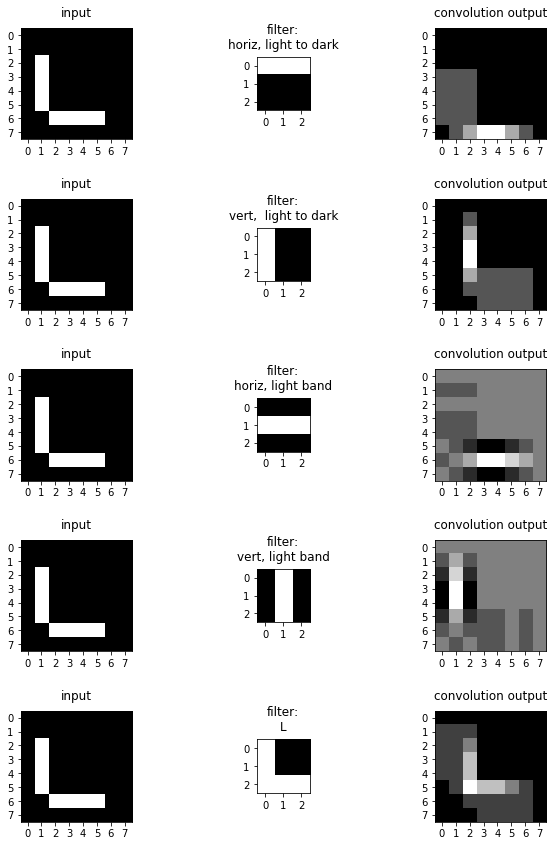

In [4]:
_= cnnh.plot_convs()

- A bright element in the output indicates a high, positive dot product
- A dark element in the output indicates a low (or highly negative) dot product

In our example
- $N = 2$: Two spatial dimensions
- One input feature: $n_{(\ll-1)} = 1$ 
- One output feature $n_\llp = 1$
- $f_\llp = 3$
    - Kernel is $(3 \times 3 \times 1)$.

The template match will be maximized when
- high values in the input correspond to high values in the matching location of the template
- low values in the input correspond to low values in the matching locations of the template

We can have "spatial" dimensions of length even greater than 2

When we want to emphasize the number of features $n_\llp$ rather than the number of spatial dimensions,
we will use ellipsis (dots)
$$\y_{\ldots, n_\llp}$$

where the ellipsis ($\ldots$) is a place-holder for the spatial dimension shape.

In [5]:
print("Done")

Done
